# Multioutput Regressor
This notebook will explore to combine the 4 outputs required {batter_runs, strike_rate, final_team_total, nrr (win margin)}. We will explore a couple of methods
- 4 Models for the 4 outputs
- Chaining Models 

Challenges: Choosing a test set

In [224]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../../Data/selected_data/processed_data_NRR_with_venues.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data['date'] = data['match_id'].apply(lambda x: x[-10: ])
data['date'] = pd.to_datetime(data['date'])

# Remove zimbabwe, ireland and Bangladesh
data = data[(data['bowling_team'] != 'Zimbabwe') & (data['batting_team'] != 'Zimbabwe')]
data = data[(data['bowling_team'] != 'Bangladesh') & (data['batting_team'] != 'Bangladesh')]
data = data[(data['bowling_team'] != 'Ireland') & (data['batting_team'] != 'Ireland')]


data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155321 entries, 0 to 215251
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   batter               155321 non-null  object        
 1   bowler               155321 non-null  object        
 2   non_striker          155321 non-null  object        
 3   runs_by_bat          155321 non-null  int64         
 4   extra_runs           155321 non-null  int64         
 5   total_runs_delivery  155321 non-null  int64         
 6   current_team_total   155321 non-null  int64         
 7   runs_remain          155321 non-null  float64       
 8   batter_runs          155321 non-null  int64         
 9   balls_faced          155321 non-null  int64         
 10  wickets_fallen       155321 non-null  int64         
 11  extra_type           155321 non-null  object        
 12  delivery             155321 non-null  float64       
 13  over               

In [206]:
data.loc[data['bowling_team'] == data['batting_team'], ['bowling_team', 'batting_team', 'match_id', 'batter', 'bowler']].count()

bowling_team    78
batting_team    78
match_id        78
batter          78
bowler          78
dtype: int64

In [12]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2]) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (
		    data['innings'].isin(innings))
	]

	player_data.head()

	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = ['date', 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over',
	    'delivery', 'wickets_fallen', 'bowling_team', 'batting_team', 'venue', 'toss_winner', 'runs_remain', 'net_run_rate', 'final_team_total']
	player_scores = gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery',
	                      'wickets_fallen', 'current_team_total']]
	first_ball['first_ball'] = (
	    first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']
	player_scores['current_team_total'] = first_ball['current_team_total']
	player_scores['is_powerplay'] = first_ball['first_ball'] <= 30

    # convert toss win to boolean
	player_scores['toss_winner'] = (
	    player_scores['toss_winner'] == player_scores['batting_team']).astype(int);

    # when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker']
	    == player_name].index

	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, [
	    'batter_runs', 'balls_faced']] = [0, 0]

	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (
	    player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]

	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)

	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(
	    player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (
	    player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)

	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs',
	    'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 +
	                          matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis=1)

	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]

		if player_data.empty:
			return player_data.drop('match_id', axis=1)

		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced

		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop(
		    'match_id', axis=1)  # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby(
	    'match_id')['bowler_type'].value_counts().unstack(fill_value=0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(
	    remaining_ball_types, how='left', on='match_id')

	player_scores.fillna(0, inplace=True)
	
    
    # if batsman ended as non_striker, make him the batter and drop the nonstriker column
	player_scores['batter'] = player_name
	player_scores.drop('non_striker', inplace=True, axis = 1)



	# Sort according to date
	player_scores.sort_values(by='date', inplace=True)

	def calculate_recent_form(row, window=30):
		"""
		Calculates the average runs scored by the player in the last 'window' days (excluding the current date).
		"""
		date = row['date']
		df = player_scores.copy()
		df = df[df['date'] < date]
		df = df[df['date'] >= (date - pd.Timedelta(days=window))]
		average_runs = df['batter_runs'].mean() if len(df) > 0 else 0
		return average_runs	

	player_scores['recent_form'] = player_scores.apply(calculate_recent_form, axis=1)
	
	# reindex
	player_scores.reset_index(drop=True, inplace=True)

	return player_scores

getPlayerScores('BKG Mendis').head()

C:\Users\kaush\AppData\Local\Temp\ipykernel_12788\3874185176.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


,match_id,date,batter,batter_runs,balls_faced,wicket_type,won,innings,wickets_fallen,bowling_team,...,strike_rate,out,last_ball,Left arm Fast,Left arm Orthodox,Left arm Wrist spin,Right arm Fast,Right arm Legbreak,Right arm Offbreak,recent_form
0,England_Sri Lanka_2016-07-05,2016-07-05,BKG Mendis,21,16,caught and bowled,0.0,1,1,England,...,131.25,True,53,24,24,0,80,49,15,0.0
1,Sri Lanka_Australia_2016-09-06,2016-09-06,BKG Mendis,22,13,caught,0.0,2,3,Australia,...,169.23,True,47,34,24,0,74,25,34,0.0
2,Sri Lanka_Australia_2016-09-09,2016-09-09,BKG Mendis,5,7,lbw,0.0,1,3,Australia,...,71.43,True,53,31,11,0,33,37,35,22.0
3,South Africa_Sri Lanka_2017-01-20,2017-01-20,BKG Mendis,1,2,caught,0.0,2,4,South Africa,...,50.00,True,47,6,0,0,28,0,0,0.0
4,South Africa_Sri Lanka_2017-01-22,2017-01-22,BKG Mendis,4,2,bowled,1.0,2,1,South Africa,...,200.00,True,15,28,41,26,71,42,6,1.0


In [13]:
import warnings
warnings.filterwarnings('ignore')

# Generate merged_df by merging all batter scores together
merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    merged_df = pd.concat([merged_df, player_scores])

merged_df.to_csv('merged_df_checkpoint.csv')

Analyzing Player AJ Finch
Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques
Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella
Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne
Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera
Analyzing Player S Prasanna
Analyzing Player BR Dunk
Analyzing Player TD Paine
Analyzing Player PJ Cummins
Analyzing Player AJ Tye
Analyzing Player JA Richardson
Analyzing Player BKG Mendis
Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga
Analyzing Player MD Shanaka
Analyzing Player JRMVB Sanjaya
Analyzing Player GD Phillips
Analyzing Player KS Williamson
Analyzing Player C Munro
Analyzing Player TC Bruce
Analyzing Player CJ Anderson
Analyzing Player C de Grandhomme
Analyzing Player L Ronchi
Analyzing Player MJ Santner
Analyzing Player BM Wheeler
Analyzing Player TG Southee
Analyzing Player TA Boult
Analyzing Player HM Amla
Analyzi

# Data Analysis to Seperate the test set

In [200]:
merged_df = pd.read_csv('merged_df_checkpoint.csv')

merged_df.drop('Unnamed: 0', inplace=True, axis=1)
merged_df.loc[merged_df['balls_faced'] == 0, 'strike_rate'] = 0  # set SR to 0, if balls faced is 0

target_cols = ['batter_runs', 'strike_rate', 'final_team_total', 'net_run_rate']
merged_df[target_cols].describe()

,batter_runs,strike_rate,final_team_total,net_run_rate
count,10604.000000,10604.000000,10604.000000,10604.000000
mean,18.187005,109.142162,152.536873,-0.307271
std,20.338427,70.123130,34.551093,1.925474
min,0.000000,0.000000,45.000000,-8.400000
25%,3.000000,62.392500,131.000000,-1.238889
50%,11.000000,107.140000,153.000000,-0.219492
75%,26.000000,150.000000,174.000000,0.600000
max,156.000000,700.000000,267.000000,8.400000


(0        2
1        3
2        3
3        0
4        1
        ..
10599    2
10600    1
10601    0
10602    0
10603    1
Name: batter_runs, Length: 10604, dtype: int64, array([  0.,   3.,  11.,  26., 156.]))


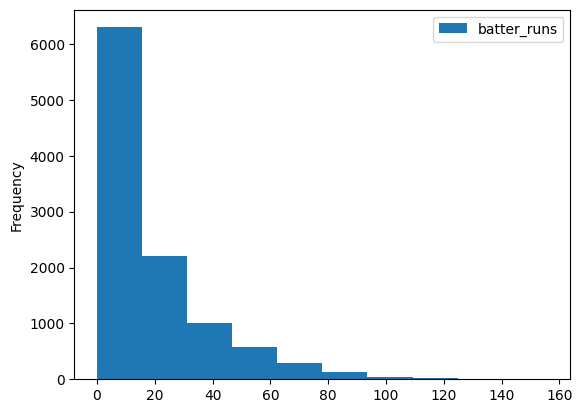

In [136]:
merged_df.plot.hist(column=['batter_runs'])
print(pd.qcut(merged_df['batter_runs'], 4, labels = False, retbins=True))

(0        2
 1        2
 2        1
 3        1
 4        2
         ..
 10599    3
 10600    1
 10601    0
 10602    2
 10603    0
 Name: net_run_rate, Length: 10604, dtype: int64,
 array([-8.4       , -1.23888889, -0.21949153,  0.6       ,  8.4       ]))

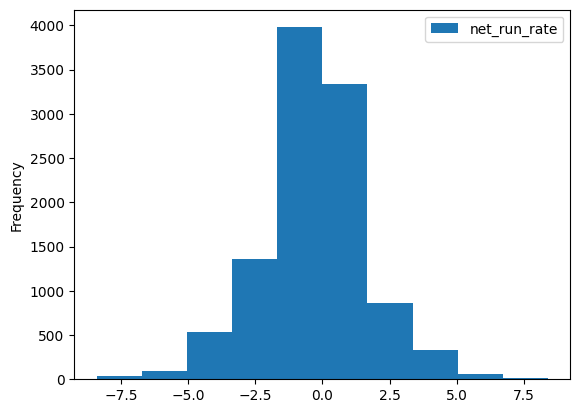

In [137]:
merged_df.plot.hist(column=['net_run_rate'])
pd.qcut(merged_df['net_run_rate'], 4, labels = False, retbins=True)

(0        1
1        1
2        0
3        0
4        0
        ..
10599    0
10600    0
10601    0
10602    0
10603    0
Name: final_team_total, Length: 10604, dtype: int64, array([ 45., 139., 166., 267.]))


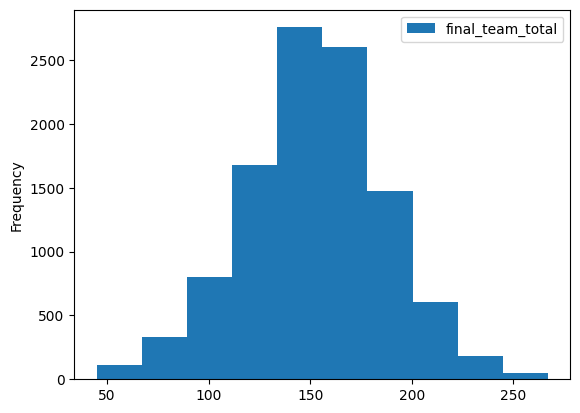

In [138]:
merged_df.plot.hist(column=['final_team_total'])
print(pd.qcut(merged_df['final_team_total'], 3, labels = False, retbins=True))

(0        1
1        2
2        2
3        0
4        1
        ..
10599    2
10600    1
10601    0
10602    0
10603    0
Name: strike_rate, Length: 10604, dtype: int64, array([  0.  ,  81.25, 133.33, 700.  ]))


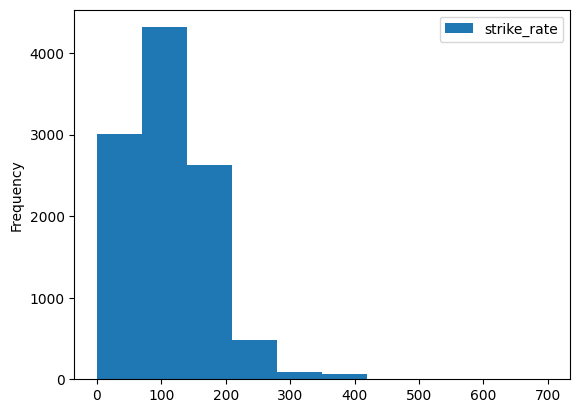

In [139]:
merged_df.plot.hist(column=['strike_rate'])
print(pd.qcut(merged_df['strike_rate'], 3, labels = False, retbins=True))

# Select matches (match_ids) from the original dataset, and separate them. 
Critieria: Date, Batting Team, Bowling Team

In [230]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


matches = data.groupby('match_id').first().reset_index()

matches['split_cat'] = ( pd.to_datetime(matches['date']).dt.strftime('%Y') + "_" +
                             matches['batting_team'].astype(str) + "_" +
                             matches['bowling_team'].astype(str))

# Identify rare categories
value_counts = matches['split_cat'].value_counts()
rare_categories = value_counts[value_counts < 3].index

# Replace rare categories with 'other'
matches['split_cat'] = matches['split_cat'].apply(lambda x: 'other' if x in rare_categories else x)


# Split Train Test Data Sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(matches, matches['split_cat']):
    train_set_ids = matches.iloc[train_index]
    test_set_ids = matches.iloc[test_index]

train_set_ids = train_set_ids['match_id'].unique()
test_set_ids = test_set_ids['match_id'].unique()

In [232]:
merged_df['match_id'].isin(train_set_ids)

0         True
1         True
2         True
3        False
4         True
         ...  
10599     True
10600     True
10601     True
10602     True
10603     True
Name: match_id, Length: 10604, dtype: bool

In [ ]:
# Separate merged_df according to the matches



In [140]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedShuffleSplit

# # Create categorical variables for each target variable by binning
# merged_df['batter_runs_cat'] = pd.cut(merged_df['batter_runs'],
#                                       bins=[  -1.,   3.,  11.,  26., np.inf],
#                                       labels=['0-3', '3-11', '11-26', '26+'])

# merged_df['strike_rate_cat'] = pd.cut(merged_df['strike_rate'],
#                                       bins=[  -1.  ,  81.25, 133.33  , np.inf],
#                                       labels=['0-81.25', '81.25-133.33', '133.33+'])

# merged_df['final_team_total_cat'] = pd.cut(merged_df['final_team_total'],
#                                            bins=[ -1., 139., 166., np.inf],
#                                            labels=['0-139', '139-166', '166+'])

# merged_df['net_run_rate_cat'] = pd.cut(merged_df['net_run_rate'],
#                                        bins=[-np.inf, -1.23888889, -0.21949153,  0.6,  np.inf],
#                                        labels=['-1.24', '- 1.24 - -0.212', '-0.219 - 0.6', '0.6+'])

# # Combine categorical variables into a single variable
# merged_df['combined_cat'] = (merged_df['batter_runs_cat'].astype(str) + "_" +
#                              merged_df['strike_rate_cat'].astype(str) + "_" +
#                              merged_df['final_team_total_cat'].astype(str) + "_" +
#                              merged_df['net_run_rate_cat'].astype(str))



# merged_df['combined_cat'].unique()
# # merged_df.drop(['combined_cat', 'batter_runs_cat', 'strike_rate_cat', 'net_run_rate_cat', 'final_team_total_cat'], inplace=True, axis=1)


array(['11-26_81.25-133.33_139-166_-0.219 - 0.6',
       '26+_133.33+_139-166_-0.219 - 0.6',
       '26+_133.33+_0-139_- 1.24 - -0.212',
       '0-3_0-81.25_0-139_- 1.24 - -0.212',
       '3-11_81.25-133.33_0-139_-0.219 - 0.6',
       '3-11_0-81.25_139-166_-1.24', '26+_133.33+_166+_0.6+',
       '3-11_81.25-133.33_166+_-1.24', '26+_133.33+_166+_- 1.24 - -0.212',
       '3-11_81.25-133.33_0-139_0.6+', '26+_133.33+_0-139_0.6+',
       '26+_81.25-133.33_166+_- 1.24 - -0.212',
       '11-26_133.33+_166+_-0.219 - 0.6', '3-11_0-81.25_0-139_-1.24',
       '3-11_0-81.25_0-139_0.6+',
       '11-26_81.25-133.33_139-166_- 1.24 - -0.212',
       '26+_81.25-133.33_139-166_-0.219 - 0.6',
       '26+_81.25-133.33_139-166_-1.24', '26+_133.33+_139-166_-1.24',
       '26+_133.33+_139-166_- 1.24 - -0.212',
       '0-3_0-81.25_166+_-0.219 - 0.6', '11-26_81.25-133.33_166+_0.6+',
       '26+_81.25-133.33_139-166_- 1.24 - -0.212',
       '26+_81.25-133.33_166+_-0.219 - 0.6',
       '11-26_81.25-133.33_166+_-

In [141]:
# # Identify rare categories
# value_counts = merged_df['combined_cat'].value_counts()
# rare_categories = value_counts[value_counts < 2].index

# # Replace rare categories with 'other'
# merged_df['combined_cat'] = merged_df['combined_cat'].apply(lambda x: 'other' if x in rare_categories else x)

# merged_df['combined_cat'].value_counts()

combined_cat
0-3_0-81.25_0-139_-1.24                586
26+_133.33+_166+_0.6+                  475
26+_133.33+_166+_-0.219 - 0.6          304
0-3_0-81.25_139-166_- 1.24 - -0.212    299
0-3_0-81.25_0-139_- 1.24 - -0.212      235
                                      ... 
0-3_133.33+_0-139_0.6+                   2
26+_0-81.25_0-139_-0.219 - 0.6           2
26+_0-81.25_139-166_- 1.24 - -0.212      2
0-3_133.33+_166+_- 1.24 - -0.212         2
11-26_0-81.25_166+_-1.24                 2
Name: count, Length: 135, dtype: int64

In [148]:
# from sklearn.model_selection import StratifiedShuffleSplit

# # Split Train Test Data Sets
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(merged_df, merged_df['combined_cat']):
#     train_set = merged_df.loc[train_index]
#     test_set = merged_df.loc[test_index]

# print("Test Set Value Counts:\n")
# print(test_set['batter_runs_cat'].value_counts() / len(test_set));
# print(test_set['strike_rate_cat'].value_counts() / len(test_set));
# print(test_set['final_team_total_cat'].value_counts() / len(test_set));
# print(test_set['net_run_rate_cat'].value_counts() / len(test_set));


# print("Train Set Value Counts:\n")
# print(train_set['batter_runs_cat'].value_counts() / len(train_set));
# print(train_set['strike_rate_cat'].value_counts() / len(train_set));
# print(train_set['final_team_total_cat'].value_counts() / len(train_set));
# print(train_set['net_run_rate_cat'].value_counts() / len(train_set));
# # Drop the categorical columns used for stratification
# for set_ in (train_set, test_set):
#     set_.drop(['batter_runs_cat', 'strike_rate_cat', 'final_team_total_cat', 'net_run_rate_cat', 'combined_cat'], axis=1, inplace=True)


Test Set Value Counts:

batter_runs_cat
0-3      0.262612
26+      0.247053
3-11     0.246110
11-26    0.244224
Name: count, dtype: float64
strike_rate_cat
0-81.25         0.335219
81.25-133.33    0.332862
133.33+         0.331919
Name: count, dtype: float64
final_team_total_cat
0-139      0.33852
166+       0.33239
139-166    0.32909
Name: count, dtype: float64
net_run_rate_cat
0.6+               0.252240
-1.24              0.249411
- 1.24 - -0.212    0.249411
-0.219 - 0.6       0.248939
Name: count, dtype: float64
Train Set Value Counts:

batter_runs_cat
0-3      0.261346
26+      0.247200
3-11     0.247082
11-26    0.244371
Name: count, dtype: float64
strike_rate_cat
0-81.25         0.333962
133.33+         0.333373
81.25-133.33    0.332665
Name: count, dtype: float64
final_team_total_cat
0-139      0.338442
166+       0.332430
139-166    0.329129
Name: count, dtype: float64
net_run_rate_cat
0.6+               0.250855
-1.24              0.249912
- 1.24 - -0.212    0.249676
-0.219 -

# Prepare data for regression, feature engineering

In [159]:
train_set = pd.read_csv('train_set.csv')
train_set.drop('Unnamed: 0', inplace=True, axis=1)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8483 entries, 0 to 8482
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             8483 non-null   object 
 1   date                 8483 non-null   object 
 2   batter               8483 non-null   object 
 3   batter_runs          8483 non-null   int64  
 4   balls_faced          8483 non-null   int64  
 5   wicket_type          8483 non-null   object 
 6   won                  8483 non-null   float64
 7   innings              8483 non-null   int64  
 8   wickets_fallen       8483 non-null   int64  
 9   bowling_team         8483 non-null   object 
 10  batting_team         8483 non-null   object 
 11  venue                8483 non-null   object 
 12  toss_winner          8483 non-null   int64  
 13  runs_remain          8483 non-null   float64
 14  net_run_rate         8483 non-null   float64
 15  final_team_total     8483 non-null   i

In [158]:
gp = data[data['match_id'].isin(train_set['match_id']) & (data['innings'] == 2)].groupby('match_id')
gp = gp.last().reset_index();


gp['first_innings_total'] = gp['final_team_total'] + gp['runs_remain'];
gp['second_innings_total'] = gp['final_team_total'];
gp.drop('final_team_total', inplace=True, axis=1);

venues_df = gp[['match_id', 'first_innings_total', 'second_innings_total', 'venue', 'won', 'host']]
venues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   match_id              659 non-null    object 
 1   first_innings_total   659 non-null    float64
 2   second_innings_total  659 non-null    int64  
 3   venue                 659 non-null    object 
 4   won                   659 non-null    float64
 5   host                  659 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 31.0+ KB
